#Riconoscimento di fiori per un’azienda AgriTech

GreenTech Solutions Ltd., un'azienda all'avanguardia nel settore dell'agricoltura tecnologica, si trova ad affrontare la necessità critica di implementare un sistema avanzato di riconoscimento automatico dei fiori all'interno delle sue operazioni quotidiane. La necessità di identificare automaticamente i fiori è cruciale per diversi motivi strategici e operativi:

1. **Ottimizzazione delle Procedure Agricole**: Il riconoscimento automatico dei fiori consente di automatizzare e accelerare processi chiave all'interno dell'agricoltura, come la valutazione della salute delle piante, la gestione dei raccolti e la programmazione delle attività di manutenzione.

2. **Monitoraggio della Salute Vegetale**: La capacità di identificare rapidamente e con precisione i fiori permette a GreenTech Solutions di monitorare la salute delle colture in tempo reale, individuando precocemente eventuali segnali di stress vegetativo, malattie o carenze nutrienti.

3. **Decisioni Basate sui Dati**: Il riconoscimento automatico dei fiori fornisce dati dettagliati e affidabili che supportano decisioni agronomiche informate, come l'ottimizzazione dei trattamenti fitosanitari, la gestione dell'irrigazione e l'allocazione delle risorse agricole.

4. **Efficienza Operativa e Riduzione dei Costi**: Automatizzare il processo di identificazione dei fiori riduce la dipendenza da risorse umane per attività ripetitive e migliorabili, consentendo a GreenTech Solutions di allocare le risorse in modo più efficiente e di ridurre i costi operativi complessivi.

**Benefici del Progetto:** L'implementazione di un modello avanzato di Computer Vision per il riconoscimento automatico dei fiori porterà numerosi vantaggi tangibili: **Aumento della Produttività**: Riduzione dei tempi dedicati all'identificazione manuale dei fiori, liberando risorse per attività più strategiche e ad alto valore aggiunto.

**Miglioramento della Qualità**: Garanzia di una classificazione più precisa e uniforme dei fiori, migliorando la qualità complessiva dei servizi e dei prodotti agricoli offerti.

**Innovazione Tecnologica**: Dimostrazione di leadership nell'adozione di tecnologie all'avanguardia, posizionando GreenTech Solutions come pioniere nell'agricoltura digitale e sostenibile.

**Dettagli del Progetto:** GreenTech Solutions Ltd. ha avviato un'iniziativa strategica per sviluppare un prototipo di modello di Computer Vision basato su intelligenza artificiale per il riconoscimento automatico dei fiori. Il dataset fornito include due categorie principali di fiori:

Daisy \(Margherita\): 529 immagini di train, 163 di validation, 77 di test.

Dandelion \(Tarassaco\): 746 immagini di train, 201 di validation, 105 di test.

**Obiettivo del Progetto:** Il principale obiettivo è sviluppare un modello altamente accurato e robusto, capace di classificare automaticamente i fiori con il miglior F1-score \(macro\) possibile sul dataset di test. L'uso di tecniche avanzate come il transfer learning e le data augmentations con la libreria timm di PyTorch è fortemente consigliato per ottimizzare le prestazioni del modello.

**Approccio Raccomandato:** Si richiede la configurazione e l'addestramento di una rete neurale profonda utilizzando PyTorch, con una documentazione dettagliata delle metodologie adottate e delle decisioni prese durante il processo di sviluppo. È essenziale valutare attentamente i vantaggi e le sfide del modello, inclusa la sua capacità di adattarsi a variazioni nelle condizioni ambientali e di produrre risultati coerenti e affidabili in scenari reali.

L'integrazione di questa soluzione innovativa permetterà a GreenTech Solutions Ltd. di consolidare ulteriormente la sua posizione nel mercato agricolo, offrendo soluzioni avanzate che migliorano l'efficienza operativa, promuovono la sostenibilità e soddisfano le crescenti esigenze dei clienti nel settore agricolo moderno.

**Dataset**

Link: https://proai-datasets.s3.eu-west-3.amazonaws.com/progetto-finale-flowes.tar.gz

**Modalità di consegna: **Link pubblico a notebook di Google Colab





# 1. Imports

In [3]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, auc, classification_report
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# 2. Load dataset

In [4]:
ROOT = '/content/drive'
DATASETS = ROOT + "/My Drive/datasets"
FLOWERS_DATA = DATASETS + "/flowers_data"
MODELS = ROOT + "/My Drive/Colab_Models"

In [5]:
from google.colab import drive
drive.mount(ROOT)

Mounted at /content/drive


In [ ]:
!mkdir $FLOWERS_DATA

In [19]:
!unzip -q flower_images_clean.zip -d $FLOWERS_DATA

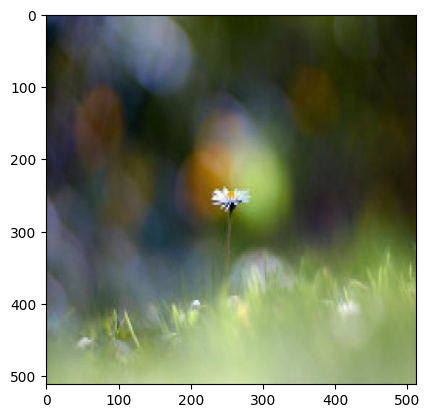

In [6]:
folder = FLOWERS_DATA + '/train/daisy/'

image_files = [f for f in os.listdir(folder) if f.endswith(('.jpg'))]
img = Image.open(folder + image_files[0])

plt.imshow(img)

In [9]:
img.size

(512, 512)

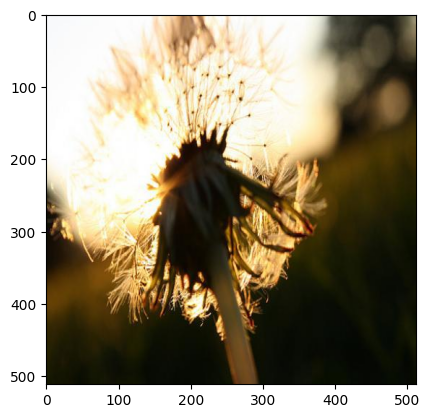

In [6]:
folder = FLOWERS_DATA + '/train/dandelion/'

image_files = [f for f in os.listdir(folder) if f.endswith(('.jpg'))]
img = Image.open(folder + image_files[0])

plt.imshow(img)

# 3. Model initialization

First we create a model based on a pre-trained ConvNeXt with ImageNet-22k from `timm`.   
https://docs.pytorch.org/vision/stable/models/convnext.html

We add a dropout and 2 output classes at the end, those would be our 2 flower types to classify.  

The parameters in the feature extractor are frozen.



In [1]:
def create_model(model_name, num_classes, verbose=False):
  model = timm.create_model(
      model_name,
      pretrained=True,
      num_classes=0
  )

  dummy_input = torch.randn(1, 3, data_config['input_size'][1], data_config['input_size'][2]) if 'data_config' in locals() else torch.randn(1, 3, 224, 224)

  if hasattr(model, 'forward_features'):
    features = model.forward_features(dummy_input)
    num_features = features.shape[1]
  else:
    num_features = model.head.fc.in_features

  model.head.fc = nn.Sequential(
      nn.Linear(num_features, 256),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(256, num_classes)
  )

  for name, param in model.named_parameters():
      if 'head' not in name:
          param.requires_grad = False
      else:
          param.requires_grad = True

  if verbose:
    print("Trainable parameters after freezing:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"  {name}")

  data_config = timm.data.resolve_model_data_config(model)
  if verbose:
    print(f"\nModel input configuration: {data_config}")

  input_size = data_config['input_size']
  dummy_image = torch.randn(1, *input_size)
  output = model(dummy_image)
  if verbose:
    print(f"Output shape: {output.shape}")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  if verbose:
    print(f"Using device: {device}")

  return model, data_config, device

In [34]:
MODEL_NAME = 'convnext_base.fb_in22k'
NUM_CLASSES = 2

In [35]:
model, data_config, device = create_model(MODEL_NAME, NUM_CLASSES, verbose=True)

Trainable parameters after freezing:
  head.norm.weight
  head.norm.bias
  head.fc.0.weight
  head.fc.0.bias
  head.fc.3.weight
  head.fc.3.bias

Model input configuration: {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
Output shape: torch.Size([1, 2])
Using device: cuda


# 2. Data Preparation and Augmentation

Here we prepare the train, test and val sets, adding some data augmentation.   
The images are croped or resized from the original 512x512 size to fit the input model 224x224.

In [36]:
TRAIN_DIR = FLOWERS_DATA + '/train'
TEST_DIR = FLOWERS_DATA + '/test'
VALID_DIR = FLOWERS_DATA + '/valid'

IMG_SIZE = data_config['input_size'][1]
NORM_MEAN = data_config['mean']
NORM_STD = data_config['std']

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=val_test_transforms)
valid_dataset = datasets.ImageFolder(VALID_DIR, transform=val_test_transforms)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"\nTrain dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Classes: {train_dataset.classes}")


Train dataset size: 1275
Test dataset size: 182
Validation dataset size: 364
Classes: ['daisy', 'dandelion']


# 3. Training

Being a classification problem we use Cross Entropy loss.

In [37]:
criterion = nn.CrossEntropyLoss()
LEARNING_RATE = 1e-4
NUM_EPOCHS = 100

In [38]:
def plot_loss_evolution(train_losses, val_losses, title="Loss Evolution"):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# 4. K-Fold Cross-Validation

For the training we're using a cross validation, that could be also beneficial given that is a small dataset.   

As optimizer we're trying AdamW, an improved version of Adam that handles weight decay. AdamW applies weight decay by directly subtracting a fraction of the weights during the weight update step, after the adaptive gradient-based update has occurred.

Also we have set up early-stopping and a learning-rate scheduler.
In the optimizer the filter is for applying it only to trainable parameters.



In [39]:
flowers_best_model_path = MODELS + '/flowers_best_model.pth'

In [40]:
K_FOLDS = 5
EARLY_STOPPING_PATIENCE = 15

combined_dataset = ConcatDataset([train_dataset, valid_dataset])
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

fold_results = {}
best_overall_val_loss = float('inf')
best_overall_model_state = None

for fold, (train_idx, val_idx) in enumerate(kf.split(combined_dataset)):
    print(f"\n--- Fold {fold+1}/{K_FOLDS} ---")

    fold_train_subset = Subset(combined_dataset, train_idx)
    fold_val_subset = Subset(combined_dataset, val_idx)

    fold_train_loader = DataLoader(fold_train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    fold_val_loader = DataLoader(fold_val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    model, data_config, device = create_model(MODEL_NAME, NUM_CLASSES)

    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=10)

    best_fold_val_loss = float('inf')
    epochs_no_improve = 0
    fold_train_losses = []
    fold_val_losses = []
    fold_train_accuracies = []
    fold_val_accuracies = []

    for epoch in range(NUM_EPOCHS):
        # Training
        model.train()
        running_train_loss = 0.0
        correct_train_predictions = 0
        total_train_predictions = 0

        for inputs, labels in fold_train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_train_predictions += labels.size(0)
            correct_train_predictions += (predicted == labels).sum().item()

        train_loss = running_train_loss / len(fold_train_subset)
        train_accuracy = correct_train_predictions / total_train_predictions
        fold_train_losses.append(train_loss)
        fold_train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        running_val_loss = 0.0
        correct_val_predictions = 0
        total_val_predictions = 0

        with torch.no_grad():
            for inputs, labels in fold_val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total_val_predictions += labels.size(0)
                correct_val_predictions += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(fold_val_subset)
        val_accuracy = correct_val_predictions / total_val_predictions
        fold_val_losses.append(val_loss)
        fold_val_accuracies.append(val_accuracy)

        print(f"  Epoch {epoch+1}/{NUM_EPOCHS}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        # LR scheduler
        scheduler.step(val_loss)

        # Early Stopping
        if val_loss < best_fold_val_loss:
            best_fold_val_loss = val_loss
            epochs_no_improve = 0
            current_fold_model_state = model.state_dict()

            if val_loss < best_overall_val_loss:
                best_overall_val_loss = val_loss
                best_overall_model_state = current_fold_model_state
                torch.save(best_overall_model_state, flowers_best_model_path)
                print(f"  Saved NEW best overall model with Validation Loss: {best_overall_val_loss:.4f}")
        else:
            epochs_no_improve += 1
            print(f"  No improvement in validation loss for {epochs_no_improve} epochs.")

        # Check early stopping
        if epochs_no_improve == EARLY_STOPPING_PATIENCE:
            print(f"  Early stopping triggered for Fold {fold+1}! Validation loss has not improved for {EARLY_STOPPING_PATIENCE} consecutive epochs.")
            break

    fold_results[f'fold_{fold+1}'] = {
        'train_losses': fold_train_losses,
        'val_losses': fold_val_losses,
        'train_accuracies': fold_train_accuracies,
        'val_accuracies': fold_val_accuracies,
        'best_val_loss': best_fold_val_loss
    }


--- Fold 1/5 ---
  Epoch 1/100: Train Loss: 0.3644, Val Loss: 0.1737, Val Acc: 0.9634
  Saved NEW best overall model with Validation Loss: 0.1737
  Epoch 2/100: Train Loss: 0.1060, Val Loss: 0.1074, Val Acc: 0.9695
  Saved NEW best overall model with Validation Loss: 0.1074
  Epoch 3/100: Train Loss: 0.0695, Val Loss: 0.1028, Val Acc: 0.9634
  Saved NEW best overall model with Validation Loss: 0.1028
  Epoch 4/100: Train Loss: 0.0552, Val Loss: 0.0837, Val Acc: 0.9604
  Saved NEW best overall model with Validation Loss: 0.0837
  Epoch 5/100: Train Loss: 0.0568, Val Loss: 0.0893, Val Acc: 0.9604
  No improvement in validation loss for 1 epochs.
  Epoch 6/100: Train Loss: 0.0553, Val Loss: 0.0752, Val Acc: 0.9756
  Saved NEW best overall model with Validation Loss: 0.0752
  Epoch 7/100: Train Loss: 0.0478, Val Loss: 0.0827, Val Acc: 0.9604
  No improvement in validation loss for 1 epochs.
  Epoch 8/100: Train Loss: 0.0454, Val Loss: 0.1005, Val Acc: 0.9787
  No improvement in validation


--- K-Fold Cross-Validation Summary ---
fold_1: Best Val Loss = 0.0652, Last Val Acc = 0.9634


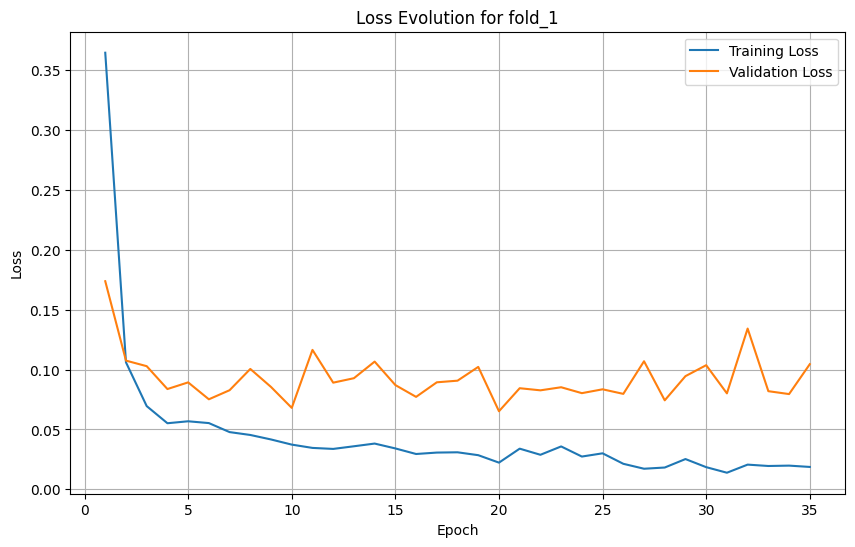

fold_2: Best Val Loss = 0.0326, Last Val Acc = 0.9665


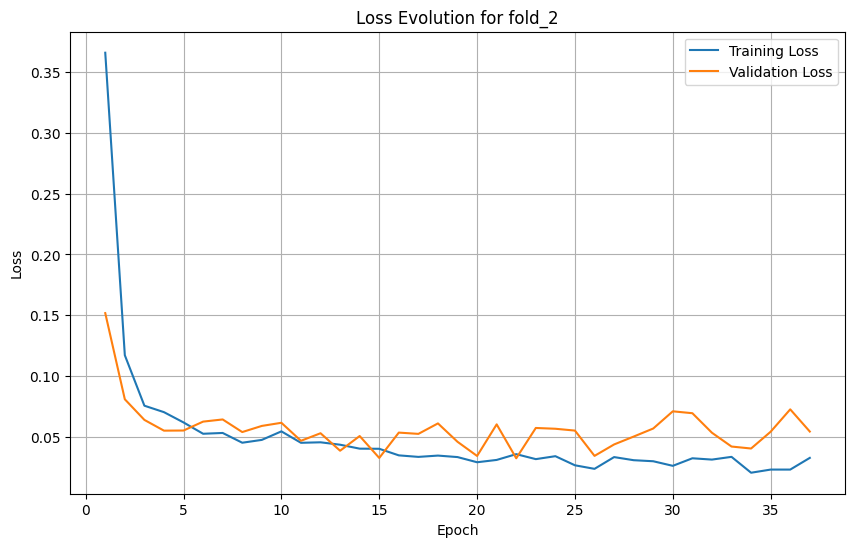

fold_3: Best Val Loss = 0.0594, Last Val Acc = 0.9756


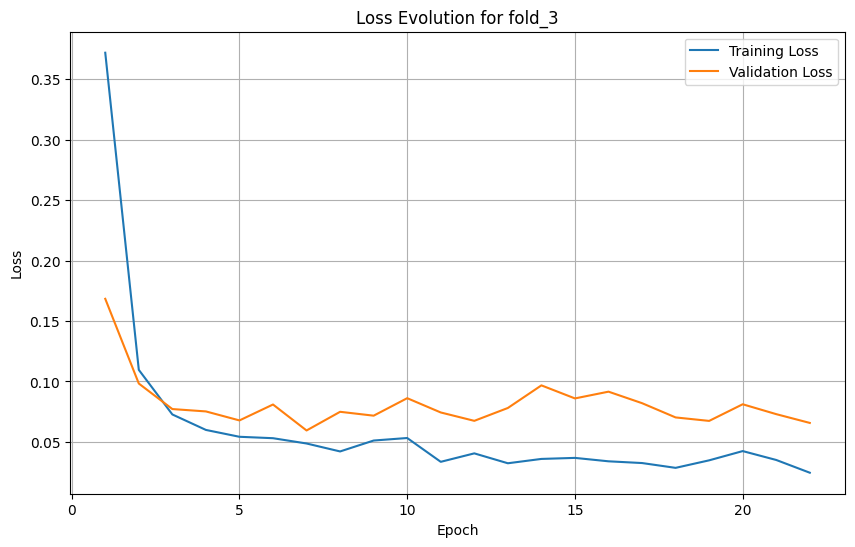

fold_4: Best Val Loss = 0.0195, Last Val Acc = 0.9817


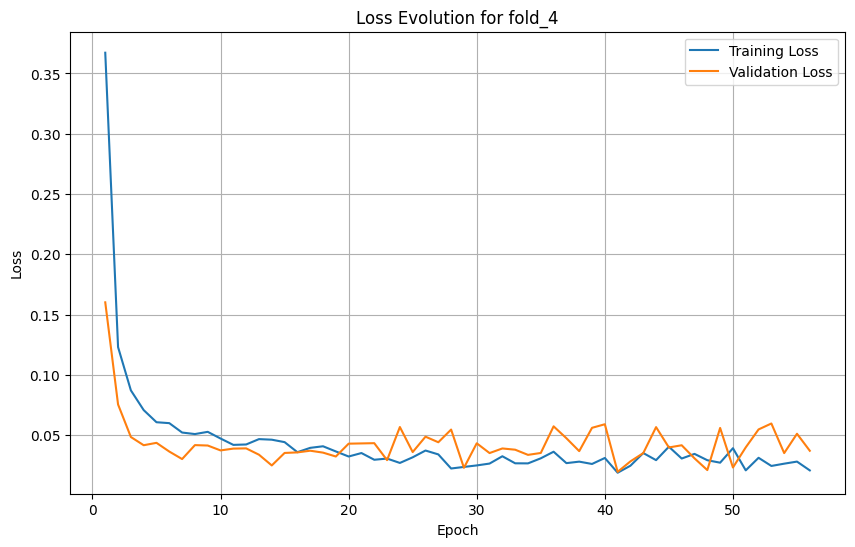

fold_5: Best Val Loss = 0.0284, Last Val Acc = 0.9694


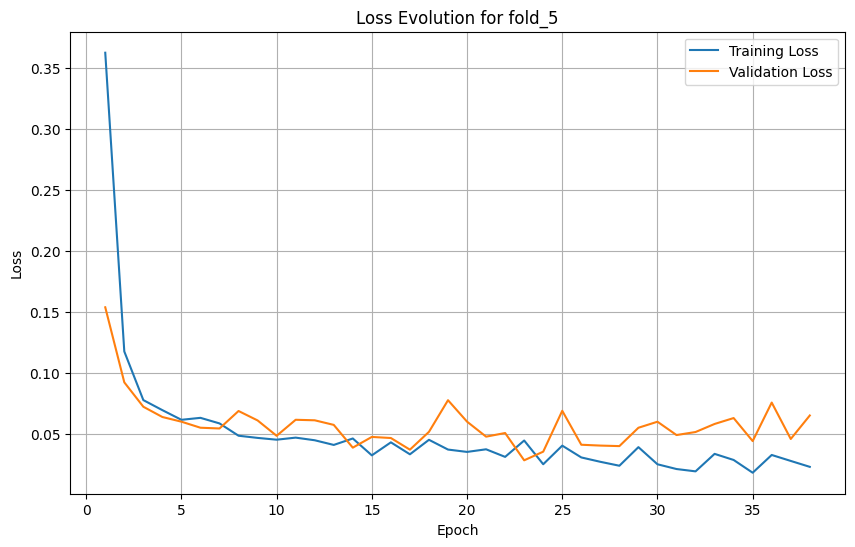

In [41]:
print("\n--- K-Fold Cross-Validation Summary ---")
for fold, results in fold_results.items():
    print(f"{fold}: Best Val Loss = {results['best_val_loss']:.4f}, Last Val Acc = {results['val_accuracies'][-1]:.4f}")
    plot_loss_evolution(results['train_losses'], results['val_losses'], title=f"Loss Evolution for {fold}")

# 5. Model Evaluation on Test Set

Finally, we evaluate the best overall model on the test set as final test.  
It's giving a pretty high F1-score (macro) 98.87% and accuracy of 98.9%, with most mismatches occurencies for dandelions (104).


Loaded best model for final test evaluation.

--- Final Test Set Evaluation (with Frozen Feature Extractor) ---
Test Loss: 0.0206
Test Accuracy: 0.9890
Test F1-Macro: 0.9887
Test ROC AUC Score: 0.9999


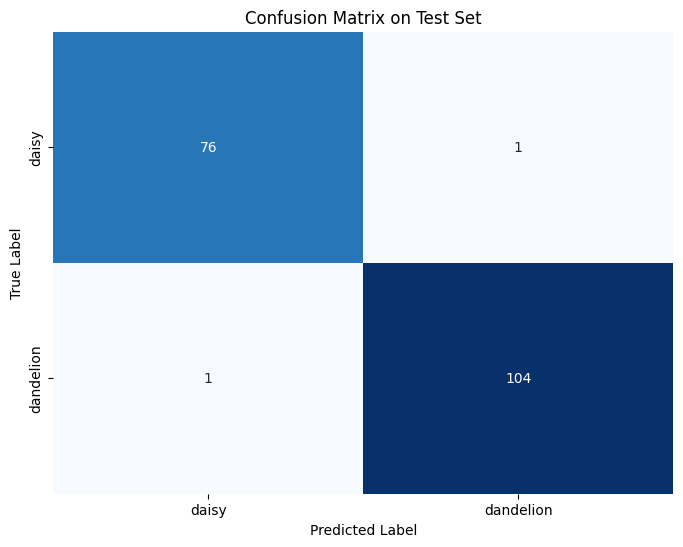


Classification Report on Test Set:
              precision    recall  f1-score   support

       daisy       0.99      0.99      0.99        77
   dandelion       0.99      0.99      0.99       105

    accuracy                           0.99       182
   macro avg       0.99      0.99      0.99       182
weighted avg       0.99      0.99      0.99       182



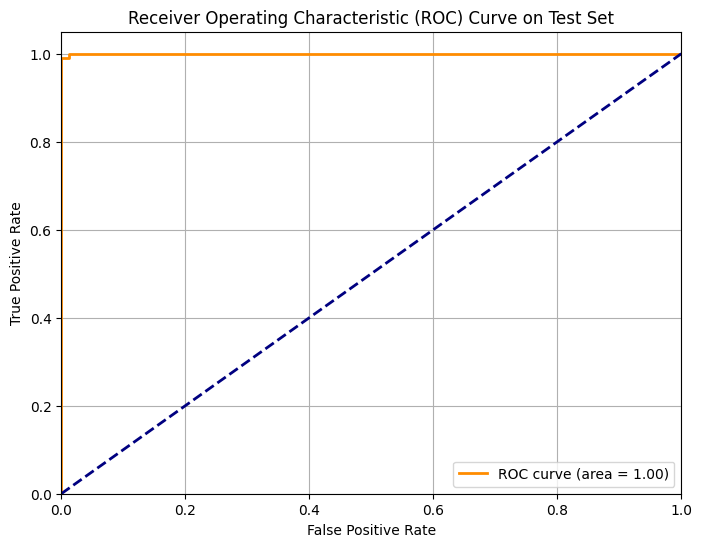

In [42]:
model, data_config, device = create_model(MODEL_NAME, NUM_CLASSES)

if os.path.exists(flowers_best_model_path):
    model.load_state_dict(torch.load(flowers_best_model_path))
    print("\nLoaded best model for final test evaluation.")
else:
    print("\nWarning: best model not found. Evaluating the last trained model from the final fold.")

model.eval()

all_test_labels = []
all_test_preds = []
all_test_probs = []
running_test_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs.data, 1)
        all_test_preds.extend(predicted.cpu().numpy())

        probabilities = torch.softmax(outputs, dim=1)[:, 1]
        all_test_probs.extend(probabilities.cpu().numpy())

        all_test_labels.extend(labels.cpu().numpy())

test_loss = running_test_loss / len(test_dataset)
test_f1_macro = f1_score(all_test_labels, all_test_preds, average='macro')
test_accuracy = np.mean(np.array(all_test_preds) == np.array(all_test_labels))
auc_score = roc_auc_score(all_test_labels, all_test_probs)

print("\n--- Final Test Set Evaluation (with Frozen Feature Extractor) ---")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Macro: {test_f1_macro:.4f}")
print(f"Test ROC AUC Score: {auc_score:.4f}")

class_names = test_dataset.classes

# Confusion Matrix
cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()


# Classification Report
print("\nClassification Report on Test Set:")
print(classification_report(all_test_labels, all_test_preds, target_names=class_names))

# ROC Curve
fpr, tpr, thresholds = roc_curve(all_test_labels, all_test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve on Test Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Pablo Di Marco.  14/07/2025